In [42]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from UNet import UNet
from CityscapesLoader import CityscapesDataset
import tqdm
import time
from torchmetrics.classification import MulticlassJaccardIndex


In [30]:
mapping_8 = {
    0: 0,  # unlabeled
    1: 0,  # unlabeled
    2: 0,  # unlabeled
    3: 0,  # unlabeled
    4: 0,  # unlabeled
    5: 0,  # unlabeled
    6: 0,  # unlabeled
    7: 1,  # road
    8: 1,  # sidewalk
    9: 1,  # parking
    10: 1,  # rail track
    11: 2,  # building
    12: 2,  # wall
    13: 2,  # fence
    14: 0,  # unlabeled
    15: 0,  # unlabeled
    16: 0,  # unlabeled
    17: 3,  # pole
    18: 0,  # unlabeled
    19: 3,  # traffic light
    20: 3,  # traffic sign
    21: 4,  # vegetation
    22: 4,  # terrain
    23: 5,  # sky
    24: 6,  # person
    25: 6,  # rider
    26: 7,  # car
    27: 7,  # truck
    28: 7,  # bus
    29: 0,  # unlabeled
    30: 0,  # unlabeled
    31: 7,  # train
    32: 7,  # motorcycle
    33: 7,  # bicycle
    -1: 0  # unlabeled
}


colormap = np.zeros((8, 3), dtype=np.uint8)
colormap[0] = [0, 0, 0]
colormap[1] = [128, 64, 128]
colormap[2] = [70, 70, 70]
colormap[3] = [153, 153, 153]
colormap[4] = [107, 142, 35]
colormap[5] = [70, 130, 180]
colormap[6] = [220, 20, 60]
colormap[7] = [0, 0, 142]


colors_normalized = [(r / 255, g / 255, b / 255) for r, g, b in colormap]

# Create a colormap with the specified colors
cmap = colors.ListedColormap(colors_normalized)

cmaplist = [cmap(i) for i in range(cmap.N)]

cmap = colors.LinearSegmentedColormap.from_list(
'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0, 8, 9)
norm = colors.BoundaryNorm(bounds, cmap.N)

In [7]:
NUM_CLASSES = 8
start_epoch = 0
epochs = 50
learning_rate = 5e-3
batch_size = 16

In [15]:
image_list = '/Cityspaces/images/train/*/*'
label_list = '/Cityspaces/gtFine/train/*/*'
train_dataset = CityscapesDataset(image_list, label_list)
image_list_val = '/Cityspaces/images/val/*/*'
label_list_val = '/Cityspaces/gtFine/val/*/*'
valid_dataset = CityscapesDataset(image_list_val, label_list_val)

<Figure size 640x480 with 0 Axes>

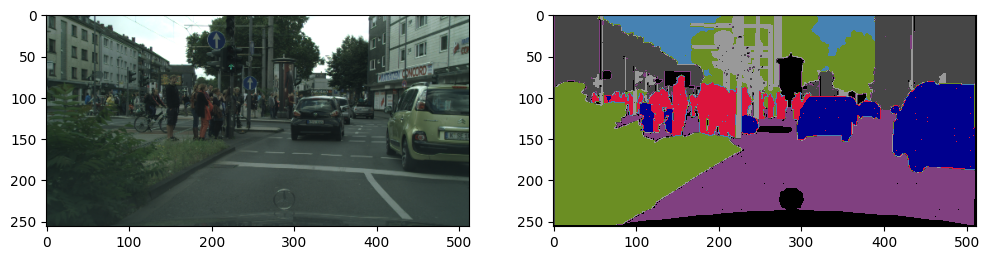

In [33]:
train_dataset, test_train_dataset = torch.utils.data.random_split(
    train_dataset, [0.8, 0.2])
valid_dataset, test_valid_dataset = torch.utils.data.random_split(
    valid_dataset, [0.8, 0.2])

test_dataset = test_train_dataset + test_valid_dataset

# divisione del dataset da aggiustare
img, mask = train_dataset.__getitem__(0)
plt.figure()
plt.figure(figsize=(12, 10), dpi=100)
plt.subplot(1, 2, 1)
plt.imshow(np.asarray(img))
plt.subplot(1, 2, 2)
plt.imshow(np.asarray(mask), cmap=cmap, norm=norm)
# Get train and val data loaders
test_loader = DataLoader(test_dataset)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
def calculate_distr(train_loader, val_loader, train_dataset, valid_dataset):
    #To calculate the distribution of the classes in the dataset
    #you can count all the pixels of the same class and divide it 
    #by the number of pixels in the dataset. Then you can use the inverse of
    #this value as the weight for the loss function.
    hist = np.zeros(NUM_CLASSES)
    tot_pix = 364380160 #previoulsy calculated
    for img, mask in tqdm.tqdm(train_loader):
        mask = mask.flatten()
        histo, bins = np.histogram(mask, NUM_CLASSES, range=[0,NUM_CLASSES-1])
        hist = hist+histo
    
        
    for img,mask in tqdm.tqdm(val_loader):
        mask = mask.flatten()
        histo, bins = np.histogram(mask, NUM_CLASSES, range=[0,NUM_CLASSES-1])
        hist = hist+histo 
    
    for idx in range(len(hist)):
        hist[idx] = hist[idx]/tot_pix 
     
    weight=[]
    
    for value in hist:
        weight.append(1/value)
        
    weight = weight/np.sum(weight)
    
    return weight
     
    
weights = calculate_distr(train_loader, val_loader, train_dataset, valid_dataset)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Definire la loss function, che può essere custom o presa dal pacchetto nn

model = UNet(3,NUM_CLASSES)
model = model.to(device)

# definire l'ottimizzatore
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer,
                              T_max = 50, # Maximum number of iterations.
                             eta_min = 5e-5) # Minimum learning rate.
loss_function = nn.CrossEntropyLoss(weight = weights,ignore_index=0)
loss_function = loss_function.to(device)

In [ ]:

def train(epochs, start_epoch, model, train_loader, val_loader, loss_function, optimizer, patch=False):
    jaccard_mean = MulticlassJaccardIndex(num_classes=NUM_CLASSES, ignore_index=0).to(device)
    train_losses = []
    test_losses = []
    val_loss = []
    val_iou = []
    train_iou = []
    min_loss = np.inf
    
    fit_time = time.time()
    
    for e in range(start_epoch, epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        
        #training loop
        model.train()
        for data, target in tqdm.tqdm(train_loader):
            #training phase

            mask= target.squeeze()
            data = data.to(device)
            mask = mask.to(device)

            optimizer.zero_grad()
            #forward
            
            output = model(data)
            # Loss and IoU evaluation
            loss = loss_function(output, mask)
            iou_score += jaccard_mean(output, mask).item()
            # backward
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        model.eval()
        val_loss = 0
        val_iou_score = 0
        #validation loop
        with torch.no_grad():
            for data, target in tqdm.tqdm(val_loader):
                output = model(data.to(device))
                mask= target.squeeze()

                mask = mask.to(device)
                
                #Loss and IoU evaluation
                val_iou_score +=  jaccard_mean(output, mask).item()
                loss = loss_function(output, mask)                          
                val_loss += loss.item()
            
        # Viene salvata la loss ad ogni epoca sia per il training che per il validation
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(val_loss/len(val_loader))

        # Viene salvato il modello solo se la validation loss è migliore degli step precedenti.
        
        if min_loss > (val_loss/len(val_loader)):
            print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (val_loss/len(val_loader))))
            min_loss = (val_loss/len(val_loader))

            print('saving model...')
            torch.save(model.state_dict(), 'UNet_best.pt')


        # Viene salvata la IoU ad ogni epoca sia per il training che per il validation
        val_iou.append(val_iou_score/len(val_loader))
        train_iou.append(iou_score/len(train_loader))

        print("Epoch:{}/{}..".format(e+1, epochs),
              "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
              "Val Loss: {:.3f}..".format(val_loss/len(val_loader)),
              "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
              "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
              "Time: {:.2f}m".format((time.time()-since)/60))
        print('saving model...')
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
              }
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [ ]:
history = train(epochs, start_epoch, model, train_loader, val_loader, loss_function, optimizer)

In [ ]:
random_idx = random.randint(0, len(test_loader)-1)
image, mask = test_dataset[random_idx]
jaccardk = MulticlassJaccardIndex(num_classes=NUM_CLASSES, ignore_index=0)
running_iou = 0
model = UNet(3,NUM_CLASSES)
model.load_state_dict(torch.load('/kaggle/input/variousmodels/Unet8class.pth', map_location=torch.device('cpu')))
model.eval()
with torch.no_grad():
    for idx , (data, target) in enumerate(test_loader):
        image = data

        output = model(data)
        
        predictions = torch.nn.functional.softmax(output, dim=1)
        pred_labels = torch.argmax(predictions, dim=1) 
        pred_labels = pred_labels.float()
        pred_labels = pred_labels.squeeze()

        #IoU evaluation
        target = target.squeeze()
        test_iou = jaccardk(pred_labels, target)
        running_iou += test_iou
        image = image.squeeze()
        im = image[0].cpu().numpy()
        mask = target.cpu().numpy()
        out = pred_labels.cpu().numpy()
        

        plt.figure()
        plt.figure(figsize=(12, 10), dpi=100)
        plt.subplot(1, 3, 1)
        plt.title("Image")
        plt.imshow(np.asarray(im))

        plt.subplot(1, 3, 2)
        plt.title("Mask")
        plt.axis("off")
        plt.imshow(mask, cmap=cmap, norm=norm)
        
        plt.subplot(1, 3, 3)
        plt.title("Prediction")
        plt.axis("off")
        plt.imshow(out, cmap=cmap, norm=norm)
        
        plt.show()
        plt.close()  

        
        print(f"Test IoU = {test_iou}")
    print('Iou_test:', running_iou/len(test_loader))